# Lesson 1 Simple RNN

simple RNN을 만들어 **시계열 예측**을 해 보고자 합니다. 데이터를 만들어 보고,값을 예측해 보도록 하겠습니다.

<img src='assets/time_prediction.png' width=40% />

> * 먼저, 예측에 사용할 데이터를 만들어 보겠습니다.
* 그리고 PyTorch를 활용해 RNN을 만듭니다.
* 그 다음 신경망을 훈련시키고 예측을 해 보겠습니다.

## 1) Import resources and create data 

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

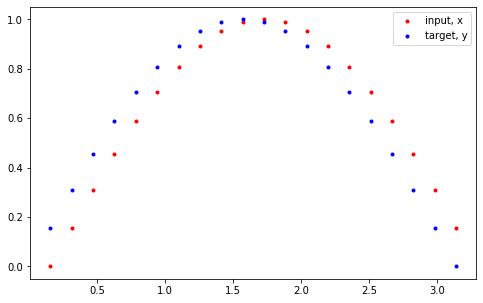

In [2]:
plt.figure(figsize=(8,5))

# 데이터의 한 batch에 얼마나 많은 time stamp 또는 data points가 있는지 정의합니다.
seq_length = 20

# 일정한 간격을 지닌 데이터 포인트를 만듧니다.
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps) 
data.resize((seq_length + 1, 1)) # (seq_length+1, 1)로 사이즈를 바꿔, input이 가능한 차원으로 바꿔줍니다.

x = data[:-1] # 마지막 데이터 포인트를 제외한 데이터
y = data[1:] # 첫번째 데이터 포인트를 제외한 데이터

# 데이터를 plot합니다 
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

---
## RNN 정의하기

이제 PyTorch의 `nn.RNN`을 사용하고 마지막에 fully-connected layer를 더해 RNN을 정의해 보겠습니다. RNN은 다음과 같은 파라미터를 받습니다.

* **input_size** - input의 사이즈 
* **hidden_dim** - RNN의 output과 hidden state에서 사용할 feature의 수
* **n_layers** - RNN을 만드는 layer의 수. 보통 1~3 사이에서 정합니다. Stacked RNN을 만들기 위해서는 1보다 큰 값을 입력해야 합니다.
* **batch_first** - 1번째 차원에서 input이나 output의 batch size를 정합니다. (batch_size, seq_length, hidden_dim)

시작하기 전에 [RNN 문서](https://pytorch.org/docs/stable/nn.html#rnn)를 읽고 RNN에 대해 더 알아봅시다.

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # RNN을 위의 parameter들을 사용해 정의합니다. 
        # batch_first는 input과 output의 첫 번째 batch의 차원을 batch_size로 정한다는 것을 의미합니다. 
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # fully-connected layer을 추가합니다. 
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # RNN의 output
        r_out, hidden = self.rnn(x, hidden)
        # output의 형태 (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # final output 
        output = self.fc(r_out)
        
        return output, hidden


### input과 output의 차원 확인

모델이 제대로 작동하는지 체크하기 위해, 위에서 정의한 input data로 실험해 보겠습니다.

In [4]:
# 차원이 적합한지 확인하기 위해 테스트 해 보겠습니다. 
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# 간격이 일정한 test data를 만듭니다.
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # 첫 번째 차원과 동일하게 batch_size를  1로 조정합니다. 
print('Input size: ', test_input.size())

# rnn size를 확인해 봅니다.
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


---
## Training the RNN

RNN을 hyperparameter를 추가해 RNN을 인스턴스화합니다. 훈련을 시킨 뒤 어떻게 작동하는 지 확인해 보겠습니다.

In [5]:
# hyperparameters를 정의합니다
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# RNN을 인스턴스화합니다.
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Loss, Optimization 정의

여기서 해결해야 하는 문제는 회귀문제입니다. RNN을 통해 다음 data point를 제대로 예측할 수 있을까요?

>* data point는 좌표값이므로, 예측값과 실제 데이터를 비교하기 위해 regrssion loss를 사용합니다. 

* recurrent model에서는 보통 Adam optimizer를 사용합니다.

In [6]:
# MSE loss와 learning rate가 0.01인 Adam optimizer를 정의합니다. 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

### Training function 정의

훈련을 위해 함수를 정의합니다. 여러 차례 훈련을 수행하고, 훈련된 RNN을 반환합니다. 또한 손실과 예측의 정확도도 표시합니다.

#### Hidden State

hidden 에 대해 살펴보는 것이 필요합니다.
* training data batch를 반복하기 전에 hidden state는 초기화됩니다. 
* RNN을 통해 새로운 hidden state가 생성되기 전, 마지막 hidden state를 얻고 이를 다음 RNN에 input으로 활용합니다.

In [7]:
# RNN을 훈련합니다.
def train(rnn, n_steps, print_every):
    
    # hidden state를 초기화합니다.
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # training data를 정의합니다. 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # data를 tensor로 변환합니다.
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze를 통해 1차원으로 바꿔, batch_size에 맞춥니다.
        y_tensor = torch.Tensor(y)

        # RNN의 output 
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # hidden state를 위한 새로운 변수를 만들고 hidden state를 history에서 지웁니다.
        # 전체 history에 backpropagate를 할 필요가 없습니다.
        hidden = hidden.data

        # loss를 계산합니다.
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # update weight를 활용해 backprop을 수행합니다. 
        loss.backward()
        optimizer.step()

        # loss와 predictions을 출력합니다.
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn


Loss:  0.3541126549243927


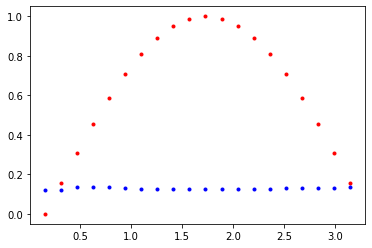

Loss:  0.05497528985142708


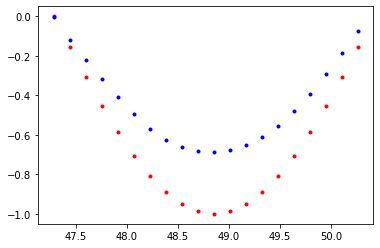

Loss:  0.011771069839596748


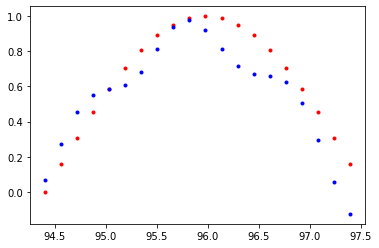

Loss:  0.0013050108682364225


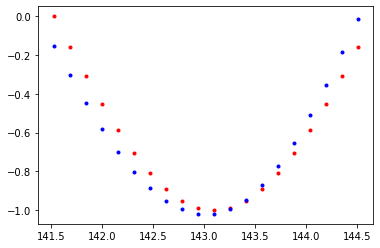

Loss:  0.0008865222334861755


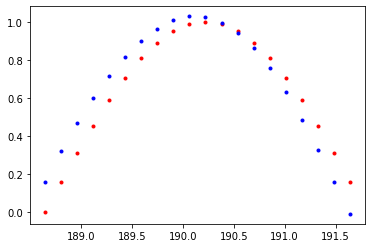

In [8]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

### 시계열 예측 

시계열 예측은 더 많은 작업에 적용할 수 있습니다. 날씨나 주식 시작 등의 흐름을 예측하는데에도 사용할수 수 있습니다. 